In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 30.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


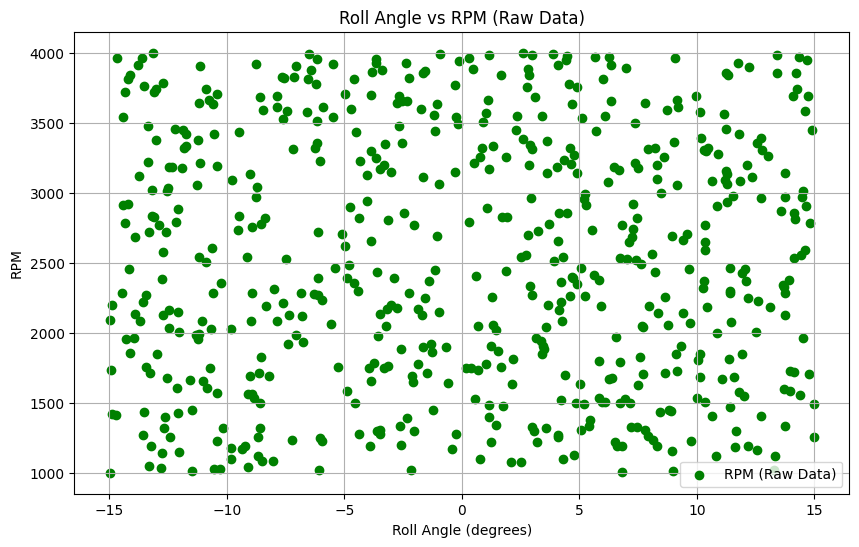

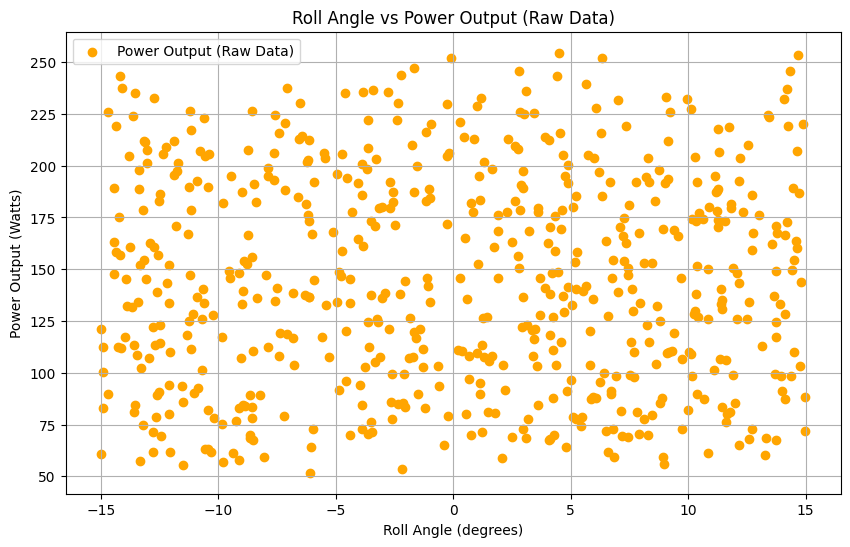

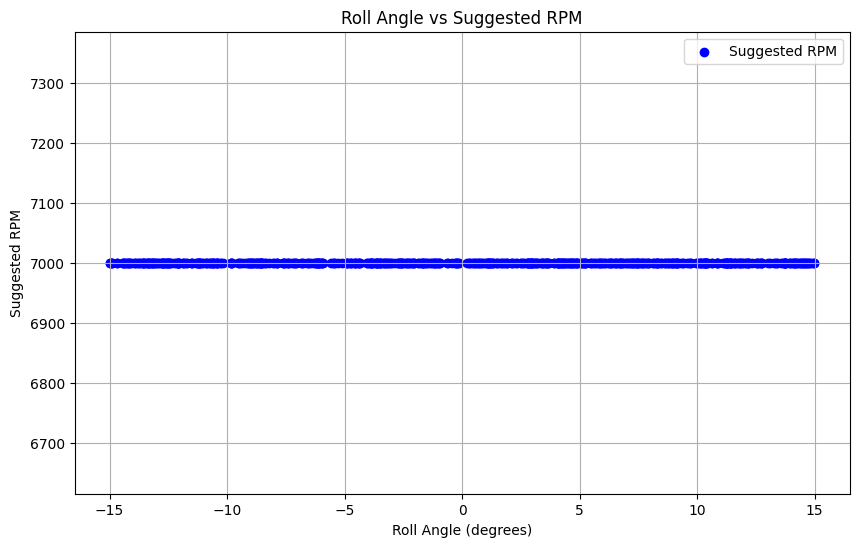

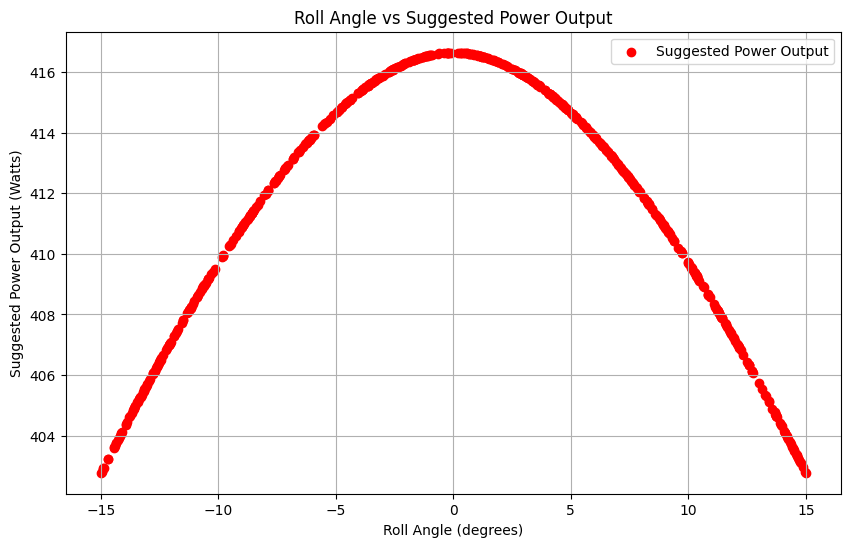

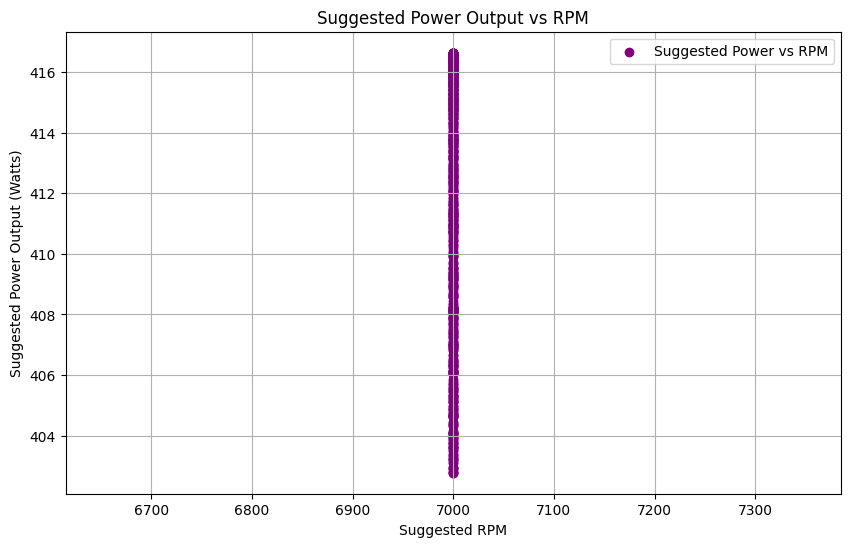

In [3]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


file1 = "/content/drive/MyDrive/Colab Notebooks/Dummy_RPM_Power_Output_Data.csv"
file2 = "/content/drive/MyDrive/Colab Notebooks/Dummy_Roll_Angle_Data.csv"


data_rpm_power = pd.read_csv(file1)
data_roll_angle = pd.read_csv(file2)


merged_data = pd.merge(data_rpm_power, data_roll_angle, on='Timestamp')


roll_angle = ctrl.Antecedent(np.linspace(-30, 30, 100), 'roll_angle')
rpm = ctrl.Antecedent(np.linspace(0, 7000, 100), 'rpm')
power_output = ctrl.Consequent(np.linspace(0, 500, 100), 'power_output')


roll_angle['low'] = fuzz.trimf(roll_angle.universe, [-30, -30, 0])
roll_angle['medium'] = fuzz.trimf(roll_angle.universe, [-30, 0, 30])
roll_angle['high'] = fuzz.trimf(roll_angle.universe, [0, 30, 30])


rpm['low'] = fuzz.trimf(rpm.universe, [0, 0, 3500])
rpm['medium'] = fuzz.trimf(rpm.universe, [0, 3500, 7000])
rpm['high'] = fuzz.trimf(rpm.universe, [3500, 7000, 7000])


power_output['low'] = fuzz.trimf(power_output.universe, [0, 0, 250])
power_output['medium'] = fuzz.trimf(power_output.universe, [0, 250, 500])
power_output['high'] = fuzz.trimf(power_output.universe, [250, 500, 500])


rule1 = ctrl.Rule(roll_angle['low'] & rpm['low'], power_output['low'])
rule2 = ctrl.Rule(roll_angle['low'] & rpm['medium'], power_output['medium'])
rule3 = ctrl.Rule(roll_angle['low'] & rpm['high'], power_output['high'])
rule4 = ctrl.Rule(roll_angle['medium'] & rpm['low'], power_output['low'])
rule5 = ctrl.Rule(roll_angle['medium'] & rpm['medium'], power_output['medium'])
rule6 = ctrl.Rule(roll_angle['medium'] & rpm['high'], power_output['high'])
rule7 = ctrl.Rule(roll_angle['high'] & rpm['low'], power_output['low'])
rule8 = ctrl.Rule(roll_angle['high'] & rpm['medium'], power_output['medium'])
rule9 = ctrl.Rule(roll_angle['high'] & rpm['high'], power_output['high'])


power_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
power_simulation = ctrl.ControlSystemSimulation(power_ctrl)


def suggest_rpm(roll_angle_value):
    best_rpm = None
    best_power = -float('inf')


    for rpm_value in np.linspace(0, 7000, 100):
        power_simulation.input['roll_angle'] = roll_angle_value
        power_simulation.input['rpm'] = rpm_value
        power_simulation.compute()


        output_power = power_simulation.output['power_output']


        if output_power > best_power:
            best_power = output_power
            best_rpm = rpm_value

    return best_rpm, best_power


def get_rpm_suggestions(merged_data):
    suggestions = []

    for index, row in merged_data.iterrows():
        roll_angle_value = row['Roll Angle (degrees)']
        suggested_rpm, suggested_power = suggest_rpm(roll_angle_value)
        suggestions.append({
            'Timestamp': row['Timestamp'],
            'Roll Angle (degrees)': roll_angle_value,
            'Suggested RPM': suggested_rpm,
            'Suggested Power Output (Watts)': suggested_power
        })

    return pd.DataFrame(suggestions)


suggested_data = get_rpm_suggestions(merged_data)


suggested_data.to_csv("/content/drive/MyDrive/Colab Notebooks/suggested_rpm_power.csv", index=False)




plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Roll Angle (degrees)'], merged_data['RPM'], label='RPM (Raw Data)', color='g', marker='o')
plt.title('Roll Angle vs RPM (Raw Data)')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('RPM')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(merged_data['Roll Angle (degrees)'], merged_data['Power Output (Watts)'], label='Power Output (Raw Data)', color='orange', marker='o')
plt.title('Roll Angle vs Power Output (Raw Data)')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Power Output (Watts)')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(suggested_data['Roll Angle (degrees)'], suggested_data['Suggested RPM'], label='Suggested RPM', color='b', marker='o')
plt.title('Roll Angle vs Suggested RPM')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Suggested RPM')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(suggested_data['Roll Angle (degrees)'], suggested_data['Suggested Power Output (Watts)'], label='Suggested Power Output', color='r', marker='o')
plt.title('Roll Angle vs Suggested Power Output')
plt.xlabel('Roll Angle (degrees)')
plt.ylabel('Suggested Power Output (Watts)')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(suggested_data['Suggested RPM'], suggested_data['Suggested Power Output (Watts)'], label='Suggested Power vs RPM', color='purple', marker='o')
plt.title('Suggested Power Output vs RPM')
plt.xlabel('Suggested RPM')
plt.ylabel('Suggested Power Output (Watts)')
plt.grid(True)
plt.legend()
plt.show()
